In [1]:
import numpy as np
import sys
sys.path.append('../corv/src')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from tqdm import tqdm
import pandas as pd

from astropy.table import Table, vstack, join
from astropy import units as u
from astropy.coordinates import SkyCoord

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c


In [2]:
"""
Load in the el-Badry dataset
"""

catalog = Table.read('data/elbadry.fits.gz')
catalog = catalog[catalog['binary_type'] == b'WDMS']

print(len(catalog))

22563


In [3]:
def wd_sep(bp_rp):
    return 3.25*bp_rp + 9.625

wd_obj = []
ms_obj = []
drop = []

for i in tqdm (range(len(catalog))):
    mg1 = wd_sep(catalog['bp_rp1'][i])
    mg2 = wd_sep(catalog['bp_rp2'][i])
    
    M1 = catalog['phot_g_mean_mag1'][i] + 5 * (np.log10(catalog['parallax1'][i] / 100))
    M2 = catalog['phot_g_mean_mag2'][i] + 5 * (np.log10(catalog['parallax2'][i] / 100))
    
    if M1 > mg1 and M2 < mg2:
        wd_obj.append(1)
        ms_obj.append(2)
    elif M2 > mg2 and M1 < mg1:
        wd_obj.append(2)
        ms_obj.append(1)
    else:
        drop.append(i)
               
catalog.remove_rows(drop)
catalog['wd_obj'] = wd_obj
catalog['ms_obj'] = ms_obj

100%|██████████| 22563/22563 [00:00<00:00, 27769.19it/s]


In [4]:
def separate(catalog, column, ms_obj, wd_obj, newname = ''):      
    mstemp_arr = [ catalog[str(column) + str(ms_obj[i])][i] for i in range(len(ms_obj)) ]
    wdtemp_arr = [ catalog[str(column) + str(wd_obj[i])][i] for i in range(len(wd_obj)) ]
    
    catalog['ms_' + str(column)] = mstemp_arr
    catalog['wd_' + str(column)] = wdtemp_arr
    return catalog

### ---

convert_cols = ['source_id', 'parallax', 'parallax_over_error', 'phot_g_mean_mag', 'phot_g_mean_flux',
                'phot_g_mean_flux_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
                'phot_rp_mean_mag', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'bp_rp', 'ra', 'ra_error', 'dec', 'dec_error', 'l', 'b']

for col in convert_cols:
    catalog = separate(catalog, col, ms_obj, wd_obj)
    
catalog['wd_m_g'] = catalog['wd_phot_g_mean_mag'] + 5 * np.log10(catalog['wd_parallax'] / 100)
catalog['ms_m_g'] = catalog['ms_phot_g_mean_mag'] + 5 * np.log10(catalog['ms_parallax'] / 100)

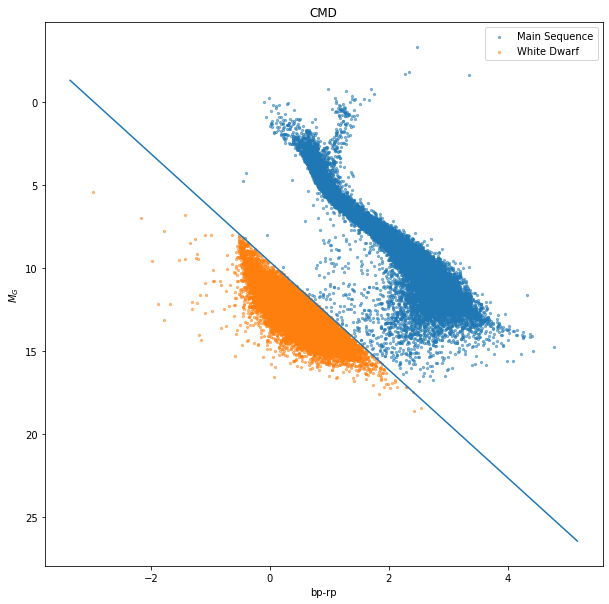

In [5]:
plt.figure(figsize=(10,10))

plt.scatter(catalog['ms_bp_rp'], catalog['ms_m_g'], label='Main Sequence', alpha = 0.5, s=5)
plt.scatter(catalog['wd_bp_rp'], catalog['wd_m_g'], label='White Dwarf', alpha = 0.5, s=5)

plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.plot(np.linspace(xmin, xmax, num=100), wd_sep(np.linspace(xmin, xmax, num=100)))

#plt.savefig('plots/selection/wd_ms_cmd.png')

plt.legend()
plt.show()

In [6]:
catalog.write('data/00_base_catalog.fits', overwrite = True)

In [7]:
from astropy.table import Table, vstack, hstack

only_rvs = True

stardats = []
iters = len(catalog) // 100

# MS Gaia Sources

for i in tqdm(range(iters)):
        ADQL_CODE1 = """SELECT sdss.original_ext_source_id as ms_bestobjid, gaia.source_id as ms_source_id, gaia.radial_velocity, gaia.radial_velocity_error
        FROM gaiadr3.gaia_source as gaia
        JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
        ON gaia.source_id = sdss.source_id      
        WHERE gaia.source_id in {} AND
        radial_velocity IS NOT null AND
        radial_velocity_error < 2""".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
        stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
        
gaia_d1 = vstack(stardats)

# MS SDSS4 Sources

for i in tqdm(range(iters)):
    ADQL_CODE1 = """SELECT sdss.original_ext_source_id as ms_bestobjid, gaia.source_id as ms_source_id, gaia.radial_velocity, gaia.radial_velocity_error
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
    ON gaia.source_id = sdss.source_id      
    WHERE gaia.source_id in {} AND
    radial_velocity IS null""".format(tuple(catalog['ms_source_id'][100*i:100*i+100]))
    stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())

gd1 = vstack(stardats)

stardats = []
iters = len(gd1) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select sp.bestObjID as ms_bestobjid, sp.plate as ms_plate, sp.mjd as ms_mjd, sp.fiberID as ms_fiberid
        from dbo.SpecObjAll as sp
        where sp.bestObjID in {}""".format(tuple(gd1['ms_bestobjid'][100*i:100*i+100]))
    
    f = SDSS.query_sql(SDSS_QUERY)
    if f is not None:
        stardats.append(SDSS.query_sql(SDSS_QUERY))

sdss_d1 = vstack(stardats)
try:
    sdss_d1 = join(sdss_d1, gd1, keys = 'ms_bestobjid')
except:
    sdss_d1.rename_column('bestobjid', 'ms_bestobjid')
    sdss_d1 = join(sdss_d1, gd1, keys = 'ms_bestobjid')

100%|██████████| 56/56 [00:00<00:00, 184.03it/s]


In [8]:
gaia_d1

ms_bestobjid,ms_source_id,radial_velocity,radial_velocity_error
,,km / s,km / s
int64,int64,float32,float32
1237667136955416660,277090609673089920,-64.18838,0.12914851
1237666465330299039,279097557694609536,-39.90621,1.4282389
1237673755495368156,3423899068823265024,5.3080435,0.9618851
1237667207828799604,1092988848060209024,5.2204475,0.12139113
1237667205679677573,1094575477700605312,-87.194626,1.3007884
1237666464265994481,1095658118696794496,-32.72011,0.7339119
1237680299422580826,2835847200516488832,-13.714442,1.6324968
1237679477466661009,2837987846577171840,-9.24535,1.5745862


In [9]:
sdss_d1

ms_bestobjid,asplate,asmjd,asfiberid,ms_source_id,radial_velocity,radial_velocity_error
,,,,,km / s,km / s
int64,int64,int64,int64,int64,float32,float32
1237648722311839804,2926,54625,337,3690807066949864704,--,--
1237648722311839804,7456,56727,550,3690807066949864704,--,--
1237649962996269183,2071,53741,520,3245310308567156864,--,--
1237651226781221865,352,51694,283,1438686535171870720,--,--
1237651226781221865,352,51789,295,1438686535171870720,--,--
1237651754532930221,4743,55645,696,3846983485264812672,--,--
1237651754532930221,480,51989,609,3846983485264812672,--,--
1237653618545197215,7096,56683,280,1047912479093335168,--,--


In [10]:
from astropy.table import Table, vstack, hstack, unique

stardats = []
iters = len(catalog) // 100

for i in tqdm(range(iters)):
    ADQL_CODE1 = """SELECT sdss.original_ext_source_id as wd_bestobjid, gaia.source_id as wd_source_id
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
    ON gaia.source_id = sdss.source_id      
    WHERE gaia.source_id in {}""".format(tuple(catalog['wd_source_id'][100*i:100*i+100]))
    stardats.append(Gaia.launch_job(ADQL_CODE1,dump_to_file=False).get_results())
    
gd2 = vstack(stardats)

stardats = []
iters = len(gd2) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select sp.bestObjID as wd_bestobjid, sp.plate as wd_plate, sp.mjd as wd_mjd, sp.fiberID as wd_fiberid
        from dbo.SpecObjAll as sp
        where sp.bestObjID in {}""".format(tuple(gd2['wd_bestobjid'][100*i:100*i+100]))
    try:
        f = SDSS.query_sql(SDSS_QUERY)
        if f is not None:
            stardats.append(SDSS.query_sql(SDSS_QUERY))
    except:
        pass
d2 = vstack(stardats)
d2 = join(d2, gd2, keys = 'wd_bestobjid')
d2 = unique(d2, keys = 'wd_bestobjid')

100%|██████████| 63/63 [00:00<00:00, 118.46it/s]


In [11]:
d2

wd_bestobjid,wd_plate,wd_mjd,wd_fiberid,wd_source_id
int64,int64,int64,int64,int64
1237646646223766042,797,52263,134,3229684152392102144
1237646648371445796,797,52263,540,3231640836412838272
1237648702985666734,4017,55329,734,4418372534027715968
1237648703530271105,346,51693,82,4407249840044108288
1237648703530598987,364,52000,300,4407411670113357568
1237648704597524530,312,51689,586,4418844563820002304
1237648705134264360,4012,55327,514,4419060480413319936
1237648705653571818,3848,55647,916,3697071117836866688
1237648705672970535,2954,54561,12,4417682242588480896


In [12]:
try:
    sdss_d1.rename_column('asplate', 'ms_plate')
    sdss_d1.rename_column('asmjd', 'ms_mjd')
    sdss_d1.rename_column('asfiberid', 'ms_fiberid')
except:
    pass

In [13]:
from astropy.table import Table, Column, MaskedColumn, join, unique


In [14]:
data = join(catalog, gaia_d1, keys = 'ms_source_id')
ms_gaia_wd_sdss4 = join(data, d2, keys = 'wd_source_id', join_type = 'inner')

data = join(catalog, sdss_d1, keys = 'ms_source_id')
ms_sdss4_wd_sdss4 = join(data, d2, keys = 'wd_source_id', join_type = 'inner')

ms_sdss5_wd_sdss4 = join(catalog, d2, keys = 'wd_source_id')

In [15]:
ms_gaia_wd_sdss4['wd_filepath'] = ['' for i in range(len(ms_gaia_wd_sdss4))]
ms_gaia_wd_sdss4['ms_filepath'] = ['' for i in range(len(ms_gaia_wd_sdss4))]
ms_gaia_wd_sdss4['uses_sdss5'] = np.zeros(len(ms_gaia_wd_sdss4))
ms_gaia_wd_sdss4['wd_rv_from'] = ['sdss4' for i in range(len(ms_gaia_wd_sdss4))]
ms_gaia_wd_sdss4['ms_rv_from'] = ['gaia' for i in range(len(ms_gaia_wd_sdss4))]
ms_gaia_wd_sdss4['wd_rv'] = 999*np.ones(len(ms_gaia_wd_sdss4))
ms_gaia_wd_sdss4['wd_e_rv'] = 999*np.ones(len(ms_gaia_wd_sdss4))

ms_sdss4_wd_sdss4['wd_filepath'] = ['' for i in range(len(ms_sdss4_wd_sdss4))]
ms_sdss4_wd_sdss4['ms_filepath'] = ['' for i in range(len(ms_sdss4_wd_sdss4))]
ms_sdss4_wd_sdss4['uses_sdss5'] = np.zeros(len(ms_sdss4_wd_sdss4))
ms_sdss4_wd_sdss4['wd_rv_from'] = ['sdss4' for i in range(len(ms_sdss4_wd_sdss4))]
ms_sdss4_wd_sdss4['ms_rv_from'] = ['sdss4' for i in range(len(ms_sdss4_wd_sdss4))]
ms_sdss4_wd_sdss4['wd_rv'] = 999*np.ones(len(ms_sdss4_wd_sdss4))
ms_sdss4_wd_sdss4['wd_e_rv'] = 999*np.ones(len(ms_sdss4_wd_sdss4))

ms_gaia_wd_sdss4 = unique(ms_gaia_wd_sdss4, keys = 'wd_source_id')
ms_sdss4_wd_sdss4 = unique(ms_sdss4_wd_sdss4, keys = 'wd_source_id')

ms_gaia_wd_sdss4.write('data/ms_gaia_wd_sdss4.fits', overwrite = True)
ms_sdss4_wd_sdss4.write('data/ms_sdss4_wd_sdss4.fits', overwrite = True)

In [16]:
ms_sdss5_wd_sdss4.write('sdss5/temp_ms_sdss5_wd_sdss4.fits', overwrite = True)

In [17]:
ms_gaia_wd_sdss4

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

In [18]:
print(len(ms_gaia_wd_sdss4))
print(len(unique(ms_gaia_wd_sdss4, keys = 'wd_source_id')))

print(len(ms_sdss4_wd_sdss4))
print(len(unique(ms_sdss4_wd_sdss4, keys = 'wd_source_id')))

153
153
17
17


In [19]:
print(ms_gaia_wd_sdss4[ms_gaia_wd_sdss4['ms_source_id'] == 875615158730751488])

solution_id1 solution_id2 source_id1 source_id2 ... ms_rv_from wd_rv wd_e_rv
                                                ...                         
------------ ------------ ---------- ---------- ... ---------- ----- -------
